# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 1: Data Collection - Web Scraping - Data Parsing

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader



<hr style='height:2px'>

In [14]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- The deliverables in Canvas are: <br/>
    a) This python notebook with your code and answers, plus a pdf version of it (see Canvas for details),<br/>
    b) the bibtex file you created, <br/>
    c) The CSV file you created, <br/>
    d) The JSON file you created. <br/>
    
- Exercise **responsible scraping**. Web servers can become slow or unresponsive if they receive too many requests from the same source in a short amount of time. Use a delay of 10 seconds between requests in your code. This helps not to get blocked by the target website. Run the webpage fetching part of the homework only once and do not re-run after you have saved the results in the JSON file (details below). 
- Web scraping requests can take several minutes. This is another reason why you should not wait until the last minute to do this homework.
- For this assignment, we will use Python 3.5 for grading.


# Data Collection - Web Scraping - Data Parsing 
 

In this homework, your goal is to learn how to acquire, parse, clean, and analyze data. Initially you will read the data from a file, and then later scrape them directly from a website. You will look for specific pieces of information by parsing the data, clean the data to prepare them for analysis, and finally, answer some questions.

In doing so you will get more familiar with three of the common file formats for storing and transferring data, which are:
- CSV, a text-based file format used for storing tabular data that are separated by some delimiter, usually comma or space.
- HTML/XML, the stuff the web is made of.
- JavaScript Object Notation (JSON), a text-based open standard designed for transmitting structured data over the web.

In [15]:
# import the necessary libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

## Help a professor parse their publications and extract information.

### Overview

In this part your goal is to parse the HTML page of a professor containing some of his/her publications, and answer some questions. This page is provided to you in the file `data/publist_super_clean.html`. There are 45 publications in descending order from No. 244 to No. 200.


In [3]:
# use this file provided
PUB_FILENAME = 'data/publist_super_clean.html'

<div class='exercise'><b> Question 1 [40 pts]: Parsing and Converting to bibTex and CSV using Beautiful Soup and python string manipulation </b></div>

A lot of the bibliographic and publication information is displayed in various websites in a not-so-structured HTML files. Some publishers prefer to store and transmit this information in a .bibTex file which looks roughly like this (we've simplified a few things):
```
@article { 
     author = "John Doyle"
     title = "Interaction between atoms"
     URL = "Papers/PhysRevB_81_085406_2010.pdf"
     journal = "Phys. Rev. B"
     volume = "81"
}
```
You will notice that this file format is a set of items, each of which is a set of key-value pairs. In the python world, you can think of this as a list of dictionaries.
If you think about spreadsheets (as represented by CSV files), they have the same structure. Each line is an item, and has multiple features, or keys, as represented by that line's value for the column corresponding to the key.

You are given an .html file containing a list of papers scraped from the author's website and you are to write the information into .bibTex and .CSV formats. A useful tool for parsing websites is BeautifulSoup  (http://www.crummy.com/software/BeautifulSoup/) (BS).  In this problem, will parse the  file using BS, which makes parsing HTML a lot easier.

**1.1** Write a function called `make_soup` that accepts a filename for an HTML file and returns a BS object.
    
**1.2** Write a function that reads in the BS object, parses it, converts it into a list of dictionaries: one dictionary per paper. Each of these dictionaries should have the following format (with different values for each publication):
```
{'author': 'L.A. Agapito, N. Kioussis and E. Kaxiras',
 'title': '"Electric-field control of magnetism in graphene quantum dots:\n Ab initio calculations"',
 'URL': 'Papers/PhysRevB_82_201411_2010.pdf',
 'journal': 'Phys. Rev. B',
 'volume': '82'}
```


**1.3** Convert the list of dictionaries into standard .bibTex format using python string manipulation, and write the results into a file called `publist.bib`.

**1.4** Convert the list of dictionaries into standard tabular .csv format using pandas, and write the results into a file called `publist.csv`. The csv file should have a header and no integer index.

    
#### HINT 
- Inspect the HTML code for tags that indicate information chunks such as `title` of the paper.  The `find_all` method of BeautifulSoup might be useful.
- Question 1.2 is better handled if you break the code into functions, each performing a small task such as finding the author(s) for each paper. 
- Question 1.3 is effectively tackled by first using python string formatting on a template string.
- Make sure you catch exceptions when needed. 
- Make sure you check for **missing data** and handle these cases as you see fit. 


#### Resources
- [BeautifulSoup Tutorial](https://www.dataquest.io/blog/web-scraping-tutorial-python/).
- More about the [BibTex format](http://www.bibtex.org).<BR>
    
### Answers 

In [4]:
# import the necessary libraries 
from bs4 import BeautifulSoup

<span class='sq'>**1.1 Write a function called `make_soup`  ...**</span>

In [5]:
def make_soup(filename: str) -> BeautifulSoup: 

    fp = open(filename)
    return(BeautifulSoup(fp,"lxml"))


In [6]:
soup = make_soup(PUB_FILENAME)

**1.2 Write a function that reads in the BS object, parses it, converts it into a list of dictionaries...**

In [7]:
# clear output before making pdf
def get_pubs(soup):
    
    raw_pubs = soup.select("ol")
    pub_list = []
    for pub in raw_pubs:

        entry = {
            'author': '',
            'title': '',
            'url': '',
            'journal': '',
            'volume': '',
        }

        a = pub.select("a")
        br = pub.select("a + br")
        ital = pub.select("i")
        b = pub.select("b")

        if a[0]:
            entry['title'] = a[0].get_text().strip()
            entry['url'] = a[0]['href']
        if br[0]:
            authors = br[0].next_sibling.string.strip()
            if ',' in authors[-1]:
                authors = authors[0:len(authors)-2]
            entry['author'] = authors
        if ital[0]:
            entry['journal'] = ital[0].get_text().strip()
        if len(b):
            entry['volume'] = b[0].get_text().strip()

        pub_list.append(entry)
        
    return(pub_list)

**1.3 Convert the list of dictionaries into the .bibTex format using python string manipulation (python string formatting on a template string is particularly useful)..**

@article { 
     author = "John Doyle"
     title = "Interaction between atoms"
     URL = "Papers/PhysRevB_81_085406_2010.pdf"
     journal = "Phys. Rev. B"
     volume = "81"
}


In [8]:
def dict2bib(pub_dict):

    bib_str = "\n@article" + r'{' + "\n\tauthor = \"{author}\",".format(**pub_dict) \
        + "\n\ttitle = {title},".format(**pub_dict) \
        + "\n\tURL = \"{url}\",".format(**pub_dict) \
        + "\n\tjournal \"{journal}\",".format(**pub_dict) \
        + "\n\tvolume = {volume}".format(**pub_dict) \
        + "\n" + r'}' + "\n"
    return(bib_str)


pub_dicts = get_pubs(soup)
bib_strings = [dict2bib(pd) for pd in pub_dicts]
text_file = open("publist.bib", "w")
[text_file.write(bs) for bs in bib_strings]
text_file.close()

** 1.4 Convert the list of dictionaries into the .csv format using pandas, and write the data into `publist.csv`. The csv file should have a header and no integer index...**

In [9]:
pub_df = pd.DataFrame(pub_dicts)
pub_df.to_csv("publist.csv", index=False)
pub_df.head(45)

,author,journal,title,url,volume
0,"Ming-Wei Lin, Cheng Ling, Luis A. Agapito, Nic...",PHYSICAL REVIEW B,"""Approaching the intrinsic band gap in suspend...",Papers/2011/PhysRevB_84_125411_2011.pdf,84
1,"JAdam Gali, Efthimios Kaxiras, Gergely T. Zima...",PHYSICAL REVIEW B,"""Effect of symmetry breaking on the optical ab...",Papers/2011/PhysRevB_84_035325_2011.pdf,84
2,"Jan M. Knaup, Han Li, Joost J. Vlassak, and Ef...",PHYSICAL REVIEW B,"""Influence of CH2 content and network defects ...",Papers/2011/PhysRevB_83_054204_2011.pdf,83
3,"Martin Heiss, Sonia Conesa-Boj, Jun Ren, Hsian...",PHYSICAL REVIEW B,"""Direct correlation of crystal structure and o...",Papers/2011/PhysRevB_83_045303_2011.pdf,83
4,"Simone Melchionna, Efthimios Kaxiras, Massimo ...",Phil. Trans. R. Soc. A,"""Endothelial shear stress from large-scale blo...",Papers/2011/PhilTransRSocA_369_2354_2011.pdf,369
5,"J R Maze, A Gali, E Togan, Y Chu, A Trifono",New Journal of Physics,"""Properties of nitrogen-vacancy centers in dia...",Papers/2011/NewJPhys_13_025025_2011.pdf,13
6,"Kejie Zhao, Wei L. Wang, John Gregoire, Matt P...",Nano Lett.,"""Lithium-Assisted Plastic Deformation of Silic...",Papers/2011/NanoLett_11_2962-2967_2011.pdf,11
7,"Masataka Katono, Takeru Bessho, Sheng Meng, Ro...",Langmuir,"""D-Ï€-A Dye System Containing Cyano-Benzoic Ac...",Papers/2011/Langmuir_27_14248_2011.pdf,27
8,"Thomas D. Kuhne, Tod A. Pascal, Efthimios Kaxi...",J. Phys. Chem. Lett.,"""New Insights into the Structure of the Vapor/...",Papers/2011/JPhysChemLett_2_105-113_2011.pdf,2
9,"Sheng Meng, Efthimios Kaxiras, Md. K. Nazeerud...",J. Phys. Chem. C,"""Design of Dye Acceptors for Photovoltaics fro...",Papers/2011/JPhysChemC_115_9276-9282_2011.pdf,115


In [10]:
# your code here


<hr style='height:2px'>
## Follow the stars in IMDb's list of "The Top 100 Stars for 2017" 

### Overview
In this part, your goal is to extract information from IMDb's Top 100 Stars for 2017 (https://www.imdb.com/list/ls025814950/) and perform some analysis on each star in the list. In particular we are interested to know: a) how many performers made their first movie at 17? b) how many performers started as child actors? c) who is the most proliferate actress or actor in IMDb's list of the Top 100 Stars for 2017? . These questions are addressed in more details in the Questions below. 

When data is not given to us in a file, we need to fetch them using one of the following ways:
- download a file from a source URL
- query a database 
- query a web API 
- scrape data from the web page

<div class='exercise'><b> Question 2 [52 pts]: Web Scraping using Beautiful Soup and exploring using Pandas </b></div>

**2.1** Download the webpage of the "Top 100 Stars for 2017" (https://www.imdb.com/list/ls025814950/) into a `requests` object and name it `my_page`. Explain what the following attributes are:

- `my_page.text`, 
- `my_page.status_code`,
- `my_page.content`.

**2.2** Create a Beautiful Soup object named `star_soup` using `my_page` as input.

**2.3** Write a function called `parse_stars` that accepts `star_soup` as its input and generates a list of dictionaries named `starlist` (see definition below; order of dictionaries does not matter). One of the fields of this dictionary is the `url` of each star's individual page, which you need to scrape and save the contents in the `page` field. Note that there is a ton of information about each star on these webpages.

```
name: the name of the actor/actress as it appears at the top
gender: 0 or 1: translate the word 'actress' into 1 and 'actor' into '0'
url: the url of the link under their name that leads to a page with details
page: BS object with html text acquired by scraping the above 'url' page' 
```

**2.4** Write a function called `create_star_table` which takes `starlist` as an input and extracts information about each star (see function definition for the exact information to be extracted and the exact output definition).  Only extract information from the first box on each star's page. If the first box is acting, consider only acting credits and the star's acting debut, if the first box is Directing, consider only directing credits and directorial debut.

**2.5** Now that you have scraped all the info you need, it's good practice to save the last data structure you created to disk. Save the data structure to a JSON file named `starinfo.json` and submit this JSON file in Canvas. If you do this, if you have to restart, you won't need to redo all the requests and parsings from before.  

**2.6** We provide a JSON file called `data/staff_starinfo.json` created by CS109 teaching staff for consistency, which you should use for the rest of the homework. Import the contents of this JSON file  into a pandas dataframe called `frame`. Check the types of variables in each column and clean these variables if needed. Add a new column to your dataframe with the age of each actor when they made their first appearance, movie or TV, (name this column `age_at_first_movie`). Check some of the values of this new column. Do you find any problems? You don't need to fix them.

**2.7** You are now ready to answer the following intriguing questions: 
- **2.7.1** How many performers made their first appearance (movie or TV) when he/she was 17 years old?

- **2.7.2** How many performers started as child actors? Define child actor as a person younger than 12 years old. 

**2.8** Make a plot of the number of credits against the name of actor/actress. Who is the most prolific actress or actor in IMDb's list of the Top 100 Stars for 2017? Define **most prolific** as the performer with the most credits.
    
### Hints
- Create a variable that groups actors/actresses by the age of their first movie. Use pandas' `.groupby` to divide the dataframe into groups of performers that for example started performing as children (age $<$ 12). The grouped variable is a `GroupBy` pandas object and this object has all of the information needed to then apply operations to each of the groups.
- When cleaning the data make sure the variables with which you are performing calculations are in numerical format.
- The column with the year has some values that are double, e.g. **'2000-2001'** and the column with age has some empty cells. You need to deal with these in a reasonable fashion before performing calculations on the data. 
- You should include both movies and TV shows.
    
### Resources
- The `requests` library makes working with HTTP requests powerful and easy. For more on the `requests` library see http://docs.python-requests.org/

### Answers

In [11]:
import requests

**2.1 Download the webpage of the "Top 100 Stars for 2017 ...**

In [12]:
url = 'https://www.imdb.com/list/ls025814950/'
my_page = requests.get(url)
print("Status Code: %i" % my_page.status_code)
print(type(my_page.text))
print(type(my_page.content))


Status Code: 200
<class 'str'>
<class 'bytes'>


* Status Code &nbsp;- &nbsp;contains a code that details whether or not the status was successful and, if not, why the request failed
* Text &nbsp;- &nbsp;contains the data of the .html formatted as a string
* Conent &nbsp;- &nbsp;contains the data of the .html formatted as bytes

*your answer here*


**2.2 Create a Beautiful Soup object named star_soup giving my_page as input.**

In [13]:
star_soup = BeautifulSoup(my_page.text, 'html.parser')

**2.3 Write a function called `parse_stars` that accepts `star_soup` as its input ...**

```
Function
--------
parse_stars

Input
------
star_soup: the soup object with the scraped page
   
Returns
-------
a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: the name of the actor/actress as it appears at the top
    gender: 0 or 1: translate the word 'actress' into 1 and 'actor' into '0'
    url: the url of the link under their name that leads to a page with details
    page: BS object with 'html text acquired by scraping the above 'url' page' 

Example:
--------
{'name': Tom Hardy,
  'gender': 0,
  'url': https://www.imdb.com/name/nm0362766/?ref_=nmls_hd,
  'page': BS object with 'html text acquired by scraping the 'url' page'
}

```

In [15]:
def parse_stars(star_soup, page_url):
    
    star_list = []
    list_items = star_soup.select("div.lister-item.mode-detail")
    for item in list_items:
        
        # pre-allocate default vals
        def_entry = {
            'name': '',
            'gender': '',
            'url': '',
            'page': '',
        }
        
        # get name and gender
        def_entry['name'] = item.select_one("h3.lister-item-header a").text.strip()
        gender = item.select_one("p.text-muted.text-small").text.split('|')[0]
        if 'Actress' in gender:
            def_entry['gender'] = 1
        elif 'Actor' in gender:
            def_entry['gender'] = 0
            
        # get url and request detailed page
        def_entry['url'] = page_url + item.select_one("h3.lister-item-header a")['href']
        print("requesting page data for\t %s \t at %s \n" % (def_entry['name'], def_entry['url']))
        star_page = requests.get(def_entry['url'])
        time.sleep(2)
        if star_page.status_code == 200:
            def_entry['page'] = star_page.text
            
        star_list.append(def_entry)
        
    return(star_list)

In [16]:
site_url = "https://www.imdb.com"
star_list = parse_stars(star_soup, site_url)

requesting page data for	 Gal Gadot 	 at https://www.imdb.com/name/nm2933757?ref_=nmls_hd 

requesting page data for	 Tom Hardy 	 at https://www.imdb.com/name/nm0362766?ref_=nmls_hd 

requesting page data for	 Emilia Clarke 	 at https://www.imdb.com/name/nm3592338?ref_=nmls_hd 

requesting page data for	 Alexandra Daddario 	 at https://www.imdb.com/name/nm1275259?ref_=nmls_hd 

requesting page data for	 Bill Skarsgård 	 at https://www.imdb.com/name/nm0803889?ref_=nmls_hd 

requesting page data for	 Pom Klementieff 	 at https://www.imdb.com/name/nm2962353?ref_=nmls_hd 

requesting page data for	 Ana de Armas 	 at https://www.imdb.com/name/nm1869101?ref_=nmls_hd 

requesting page data for	 Dan Stevens 	 at https://www.imdb.com/name/nm1405398?ref_=nmls_hd 

requesting page data for	 Sofia Boutella 	 at https://www.imdb.com/name/nm1154749?ref_=nmls_hd 

requesting page data for	 Katherine Langford 	 at https://www.imdb.com/name/nm7692698?ref_=nmls_hd 

requesting page data for	 Karen Gilla

requesting page data for	 Auli'i Cravalho 	 at https://www.imdb.com/name/nm7635388?ref_=nmls_hd 

requesting page data for	 Mädchen Amick 	 at https://www.imdb.com/name/nm0000749?ref_=nmls_hd 

requesting page data for	 Serinda Swan 	 at https://www.imdb.com/name/nm2100657?ref_=nmls_hd 

requesting page data for	 Dave Bautista 	 at https://www.imdb.com/name/nm1176985?ref_=nmls_hd 

requesting page data for	 Rose Leslie 	 at https://www.imdb.com/name/nm3310211?ref_=nmls_hd 

requesting page data for	 Annabelle Wallis 	 at https://www.imdb.com/name/nm1834115?ref_=nmls_hd 

requesting page data for	 Zoey Deutch 	 at https://www.imdb.com/name/nm3614913?ref_=nmls_hd 

requesting page data for	 Sophie Turner 	 at https://www.imdb.com/name/nm3849842?ref_=nmls_hd 

requesting page data for	 Dakota Johnson 	 at https://www.imdb.com/name/nm0424848?ref_=nmls_hd 

requesting page data for	 Rosamund Pike 	 at https://www.imdb.com/name/nm0683253?ref_=nmls_hd 

requesting page data for	 Elodie Yung 	

This should give you 100

In [17]:
len(star_list)

100

Your output should look like this:
```
{'name': 'Gal Gadot',
 'gender': 1,
 'url': 'https://www.imdb.com/name/nm2933757?ref_=nmls_hd',
 'page': 
 <!DOCTYPE html>
 
 <html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
 <meta charset="utf-8"/>
 <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
 <meta content="app-id=342792525, app-argument=imdb:///name/nm2933757?src=mdot" name="apple-itunes-app"/>
 <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
 <script>
     if (typeof uet == 'function') {
       uet("bb", "LoadTitle", {wb: 1});
     }
 </script>
 <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
 
... 


 ```

**2.4 Write a function called `create_star_table` to extract information about each star ...**

```
Function
--------
create_star_table

Input
------
the starlist
   
Returns
-------

a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    star_name: the name of the actor/actress as it appears at the top
    gender: 0 or 1 (1 for 'actress' and 0 for 'actor')  
    year_born : year they were born
    first_movie: title of their first movie or TV show
    year_first_movie: the year they made their first movie or TV show
    credits: number of movies or TV shows they have made in their career.
    
--------
Example:

{'star_name': Tom Hardy,
  'gender': 0,
  'year_born': 1997,
  'first_movie' : 'Batman',
  'year_first_movie' : 2017,
  'credits' : 24}
  
```

In [45]:
import re

In [72]:
def create_star_table(starlist: list) -> list:

    star_table = []
    for i in range(len(starlist)):
        
        star = starlist[i]
        def_entry = {
            'star_name': star['name'],
            'gender': star['gender'],
            'year_born': -1,
            'first_movie' : '',
            'year_first_movie' : -1,
            'credits' : -1,
        }

        print(i, end=", ", flush=True)
        star_page_soup = BeautifulSoup(star['page'], 'html.parser')
        job_info = star_page_soup.select_one('div#name-job-categories')
        job_titles = [job.text.strip() for job in job_info.findAll('a')]
        job_re = '^(' + job_titles[0] + ')'
        filmography = star_page_soup.select_one("div#filmography")
        film_list = filmography.findAll('div', id=re.compile(job_re.lower()))
        
        bday = star_page_soup.select_one("div.article.name-overview time")
        if bday:
            def_entry['year_born'] = bday['datetime'][0:4]
        def_entry['credits'] = len(film_list)
        film_list = [film for film in film_list if film.select_one("span.year_column")]
        film_list = [film for film in film_list if film.select_one("span.year_column").text.strip().isnumeric()]
        film_years = [film.select_one("span.year_column").text.strip() for film in film_list]
        p = sorted(range(len(film_years)), key=lambda k: film_years[k])
        first_film_year = film_years[p[0]]
        first_year_films = [film for film in film_list if first_film_year in film.select_one("span.year_column").text.strip()]
        def_entry['first_movie'] = first_year_films[-1].select_one("b a").text
        def_entry['year_first_movie'] = first_film_year
        
        star_table.append(def_entry)
        
    print("parsing complete")    
    return(star_table)
        
        
    


In [73]:
star_table = create_star_table(star_list)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, parsing complete


Your output should look like this (the order of elements is not important):
```
[{'name': 'Gal Gadot',
  'gender': 1,
  'year_born': '1985',
  'first_movie': 'Bubot',
  'year_first_movie': '2007',
  'credits': '25'},
 {'name': 'Tom Hardy',
  'gender': 0,
  'year_born': '1977',
  'first_movie': 'Tommaso',
  'year_first_movie': '2001',
  'credits': '55'},
  
...
```

**2.5 Now that you have scraped all the info you need, it's a good practice to save the last data structure you ...**

In [11]:
import json
with open('starinfo.json', 'w') as outfile:
    json.dump(star_table, outfile)

NameError: name 'star_table' is not defined

To check your JSON saving, re-open the JSON file and reload the code

**2.6 Import the contents of the staff's JSON file (`data/staff_starinfo.json`) into a pandas dataframe. ...**

In [12]:
with open("data/staff_starinfo.json", "r") as fd:
    star_table = json.load(fd)


In [17]:
frame = pd.DataFrame(star_table)
frame.head()

,credits,first_movie,gender,name,year_born,year_first_movie
0,25,Bubot,1,Gal Gadot,1985,2007
1,55,Tommaso,0,Tom Hardy,1977,2001
2,17,Doctors,1,Emilia Clarke,1986,2009
3,51,All My Children,1,Alexandra Daddario,1986,2002-2003
4,30,Järngänget,0,Bill Skarsgård,1990,2000


In [18]:
# some year first movie entries have a year range which I will default to the first year listed

frame['year_first_movie'] = [year[:4] for year in frame['year_first_movie']]
frame.head(10)

,credits,first_movie,gender,name,year_born,year_first_movie
0,25,Bubot,1,Gal Gadot,1985,2007
1,55,Tommaso,0,Tom Hardy,1977,2001
2,17,Doctors,1,Emilia Clarke,1986,2009
3,51,All My Children,1,Alexandra Daddario,1986,2002
4,30,Järngänget,0,Bill Skarsgård,1990,2000
5,27,Après lui,1,Pom Klementieff,1986,2007
6,23,Una rosa de Francia,1,Ana de Armas,1988,2006
7,37,Frankenstein,0,Dan Stevens,1982,2004
8,17,Le défi,1,Sofia Boutella,1982,2002
9,8,Story of Miss Oxygen,1,Katherine Langford,1996,2015


In [19]:
frame.year_born = frame.year_born.astype('uint16')
frame.year_first_movie = frame.year_first_movie.astype('uint16')
frame.credits = frame.credits.astype('uint16')
frame['age_first_movie'] = frame.year_first_movie - frame.year_born
frame.head()

,credits,first_movie,gender,name,year_born,year_first_movie,age_first_movie
0,25,Bubot,1,Gal Gadot,1985,2007,22
1,55,Tommaso,0,Tom Hardy,1977,2001,24
2,17,Doctors,1,Emilia Clarke,1986,2009,23
3,51,All My Children,1,Alexandra Daddario,1986,2002,16
4,30,Järngänget,0,Bill Skarsgård,1990,2000,10


Some of the year_first_movie entries were specified as a range. It's likely more interesting when their career began than when their first film finished production. So this column was simplified to the earliest year listed. Furthermore, the year info was stored as a string, which is problematic for calculating the age at the time of their first movie. So these were converted in unsigned 16-bit intergers.

**2.7 You are now ready to answer the following intriguing questions**:

**2.7.1 How many performers made their first movie at 17?**

In [20]:
print("%i performers made their first movie at 17" % np.sum(frame.age_first_movie == 17))

8 performers made their first movie at 17


Your output should look like this:<BR>
8 performers made their first movie at 17

**2.7.2 How many performers started as child actors? Define child actor as a person less than 12 years old.** 

In [21]:
print("%i performers started as child actors" % np.sum(frame.age_first_movie < 12))

19 performers started as child actors


**2.8 Make a plot of the number of credits versus the name of actor/actress.**

Text(0.5,0,'credits')

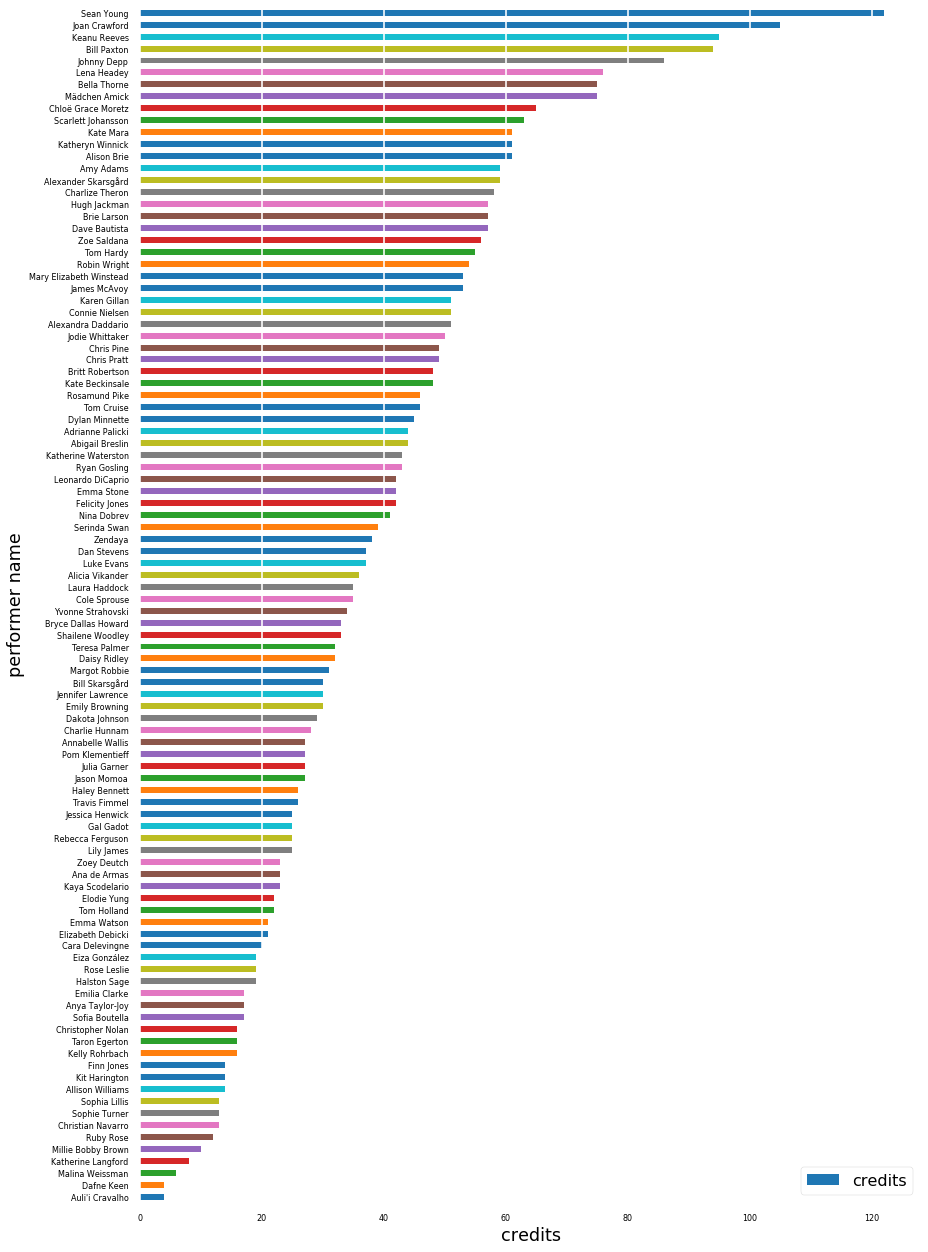

In [61]:
sorted_by_credits = frame.sort_values(by=['credits'], ascending=True)[['name', 'credits']]
sorted_by_credits.plot.barh(x='name', y='credits', fontsize=8, figsize=(14, 22))
plt.grid(axis = 'x', color ='white', linestyle='-')
plt.gca().tick_params(axis='both', which='both',length=0)
sns.despine(left=True, bottom=True)
plt.ylabel("performer name")
plt.xlabel("credits")

The most prolific entertainer on this list is Sean Young with 122 credits.

<hr style="height:2px">
##  Going the Extra Mile 
Be sure to complete problems 1 and 2 before tackling this problem...it is worth only 8 points.


<div class='exercise'> <b>Question 3 [8 pts]: Parsing using Regular Expressions (regex) </b></div>

Even though scraping HTML with regex is sometimes considered bad practice, you are to use python's **regular expressions** to answer this problem.  Regular expressions are useful to parse strings, text, tweets, etc. in general (for example, you may encounter a non-standard format for dates at some point). Do not use BeautifulSoup to answer this problem.

 **3.1** Write a function called `get_pubs` that takes an .html filename as an input and returns a string containing the HTML page in this file (see definition below). Call this function using `data/publist_super_clean.html` as input and name the returned string `prof_pubs`. 
 
 **3.2** Calculate how many times the author named '`C.M. Friend`' appears in the list of publications. 
 
 **3.3** Find all unique journals and copy them in a variable named `journals`.  
 
 **3.4** Create a list named `pub_authors` whose elements are strings containing the authors' names for each paper. 
    
### Hints
- Look for patterns in the HTML tags that reveal where each piece of information such as the title of the paper, the names of the authors, the journal name, is stored. For example, you might notice that the journal name(s) is contained between the &lt;I&gt; HTML tag. 
- Learning about your domain is always a good idea: you want to check the names to make sure that they belong to actual journals. Thus, while journal name(s) is contained between the &lt;I&gt; HTML tag, please note that <i>all</i> strings found between &lt;I&gt; tags may not be journal names.
- Each publication has multiple authors. 
- `C.M. Friend` also shows up as `Cynthia M. Friend` in the file.  Count just `C. M. Friend`. 
- There is a comma at the end of the string of authors. You can choose to keep it in the string or remove it and put it back when you write the string as a BibTex entry. 
- You want to remove duplicates from the list of journals. Duplicates may also occur due to misspellings or spaces, such as: `Nano Lett.`, and `NanoLett.` You can assume that any journals with the same initials (e.g., `NL` for `NanoLett.`) are the same journal.

### Resources
- **Regular expressions:** a) https://docs.python.org/3.3/library/re.html, b) https://regexone.com, and c) https://docs.python.org/3/howto/regex.html. 
- ** HTML:** if you are not familiar with HTML see https://www.w3schools.com/html/ or one of the many tutorials on the internet. 
- ** Document Object Model (DOM):** for more on this programming interface for HTML and XML documents see https://www.w3schools.com/js/js_htmldom.asp. 

### Answers

** 3.1  Write a function called `get_pubs` that takes an .html filename as an input and returns a string  ... **    

In [1]:
# first import the necessary reg expr library
import re

In [2]:
# use this file provided
PUB_FILENAME = 'data/publist_super_clean.html'

In [3]:
def get_pubs(filename: str):

    fp = open(filename)
    return(fp.read())

In [4]:
prof_pubs = get_pubs(PUB_FILENAME)

In [5]:
# checking your code 
# clear/remove output before creating the pdf file
print(prof_pubs)

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
   "http://www.w3.org/TR/html4/loose.dtd">

<TITLE>Kaxiras E journal publications</TITLE>
<HEAD>
<meta http-equiv="Content-Type" content="text/html;charset=UTF-8">
<LINK REL="stylesheet" TYPE="text/css" HREF="../styles/style_pubs.css">
<META NAME="description" CONTENT="">
<META NAME="keywords" CONTENT="Kaxiras E, Multiscale Methods, Computational Materials" >
</HEAD>

<BODY>

<OL START=244>
<LI>
<A HREF="Papers/2011/PhysRevB_84_125411_2011.pdf" target="paper244">
&quot;Approaching the intrinsic band gap in suspended high-mobility graphene nanoribbons&quot;</A>
<BR>Ming-Wei Lin, Cheng Ling, Luis A. Agapito, Nicholas Kioussis, Yiyang Zhang, Mark Ming-Cheng Cheng,
<I>PHYSICAL REVIEW B </I> <b>84</b>,  125411 (2011)
<BR>
</LI>
</OL>

<OL START=243>
<LI>
<A HREF="Papers/2011/PhysRevB_84_035325_2011.pdf" target="paper243">
&quot;Effect of symmetry breaking on the optical absorption of semiconductor nanoparticles&quot;</A>
<BR>JAd

You should see an HTML page that looks like this (colors are not important)
```html
<LI>
<A HREF="Papers/2011/PhysRevB_84_125411_2011.pdf" target="paper244">
&quot;Approaching the intrinsic band gap in suspended high-mobility graphene nanoribbons&quot;</A>
<BR>Ming-Wei Lin, Cheng Ling, Luis A. Agapito, Nicholas Kioussis, Yiyang Zhang, Mark Ming-Cheng Cheng,
<I>PHYSICAL REVIEW B </I> <b>84</b>,  125411 (2011)
<BR>
</LI>
</OL>

<OL START=243>
<LI>
<A HREF="Papers/2011/PhysRevB_84_035325_2011.pdf" target="paper243">
&quot;Effect of symmetry breaking on the optical absorption of semiconductor nanoparticles&quot;</A>
<BR>JAdam Gali, Efthimios Kaxiras, Gergely T. Zimanyi, Sheng Meng,
<I>PHYSICAL REVIEW B </I> <b>84</b>,  035325 (2011)
<BR>
</LI>
</OL>

<OL START=242>
<LI>
<A HREF="Papers/2011/PhysRevB_83_054204_2011.pdf" target="paper242">
&quot;Influence of CH2 content and network defects on the elastic properties of organosilicate glasses&quot;</A>
<BR>Jan M. Knaup, Han Li, Joost J. Vlassak, and Efthimios Kaxiras,
<I>PHYSICAL REVIEW B </I> <b>83</b>,  054204 (2011)
<BR>
</LI>
</OL>
    ```

**3.2 Calculate how many times the author ... **

In [161]:
res = re.findall('C.M. Friend',prof_pubs)
print(len(res))

5


**3.3 Find all unique journals and copy ...**

In [6]:
all_journals = re.findall('(?<=I>).*(?=</I>)',prof_pubs)
all_journals = [j.strip() for j in all_journals]
journals = list(set(all_journals))
journals.sort()

In [7]:
# check your code 
journals

['2010 ACM/IEEE International Conference for High Performance',
 'ACSNano.',
 'Ab initio',
 'Acta Mater.',
 'Catal. Sci. Technol.',
 'Chem. Eur. J.',
 'Comp. Phys. Comm.',
 'Concurrency Computat.: Pract. Exper.',
 'Energy & Environmental Sci.',
 'Int. J. Cardiovasc. Imaging',
 'J. Chem. Phys.',
 'J. Chem. Theory Comput.',
 'J. Phys. Chem. B',
 'J. Phys. Chem. C',
 'J. Phys. Chem. Lett.',
 'J. Stat. Mech: Th. and Exper.',
 'Langmuir',
 'Molec. Phys.',
 'Nano Lett.',
 'NanoLett.',
 'New J. Phys.',
 'New Journal of Physics',
 'PHYSICAL REVIEW B',
 'Phil. Trans. R. Soc. A',
 'Phys. Rev. B',
 'Phys. Rev. E - Rap. Comm.',
 'Phys. Rev. Lett.',
 'Sci. Model. Simul.',
 'Sol. St. Comm.',
 'Top. Catal.']

Your output should look like this (no duplicates):
```
{'2010 ACM/IEEE International Conference for High Performance',
 'ACSNano.',
 'Ab initio',
 'Acta Mater.',
 'Catal. Sci. Technol.',
 'Chem. Eur. J.',
 'Comp. Phys. Comm.',
 'Concurrency Computat.: Pract. Exper.',
 'Energy & Environmental Sci.',
 'Int. J. Cardiovasc. Imaging',
 'J. Chem. Phys.',
 'J. Chem. Theory Comput.',
 'J. Phys. Chem. B',
 'J. Phys. Chem. C',
 'J. Phys. Chem. Lett.',
 'J. Stat. Mech: Th. and Exper.',
 'Langmuir',
 'Molec. Phys.',
 'Nano Lett.',
 'New Journal of Physics',
 'PHYSICAL REVIEW B',
 'Phil. Trans. R. Soc. A',
 'Phys. Rev. E - Rap. Comm.',
 'Phys. Rev. Lett.',
 'Sci. Model. Simul.',
 'Sol. St. Comm.',
 'Top. Catal.'}
 ```

**3.4 Create a list named `pub_authors`...**

In [8]:
author_re = re.compile('(?<=BR>).*(?=,)')
pub_authors = re.findall(author_re, prof_pubs)
pub_authors = [a.strip() for a in pub_authors]

In [9]:
# check your code: print the list of strings containing the author(s)' names
for item in pub_authors:
    print (item)

Ming-Wei Lin, Cheng Ling, Luis A. Agapito, Nicholas Kioussis, Yiyang Zhang, Mark Ming-Cheng Cheng
JAdam Gali, Efthimios Kaxiras, Gergely T. Zimanyi, Sheng Meng
Jan M. Knaup, Han Li, Joost J. Vlassak, and Efthimios Kaxiras
Martin Heiss, Sonia Conesa-Boj, Jun Ren, Hsiang-Han Tseng, Adam Gali
Simone Melchionna, Efthimios Kaxiras, Massimo Bernaschi and Sauro Succi
J R Maze, A Gali, E Togan, Y Chu, A Trifonov
Kejie Zhao, Wei L. Wang, John Gregoire, Matt Pharr, Zhigang Suo
Masataka Katono, Takeru Bessho, Sheng Meng, Robin Humphry-Baker, Guido Rothenberger
Thomas D. Kuhne, Tod A. Pascal, Efthimios Kaxiras, and Yousung Jung
Sheng Meng, Efthimios Kaxiras, Md. K. Nazeeruddin, and Michael Gratzel
Bingjun Xu, Jan Haubrich, Thomas A. Baker, Efthimios Kaxiras, and Cynthia M. Friend
Jun Ren, Sheng Meng, Yi-Lin Wang, Xu-Cun Ma, Qi-Kun Xue, Efthimios Kaxiras
Jan Haubrich, Efthimios Kaxiras, and Cynthia M. Friend
Thomas A. Baker, Bingjun Xu, Stephen C. Jensen, Cynthia M. Friend and Efthimios Kaxiras
You

Your output should look like this (a line for each paper's authors string of names)
```
Ming-Wei Lin, Cheng Ling, Luis A. Agapito, Nicholas Kioussis, Yiyang Zhang, Mark Ming-Cheng Cheng,
JAdam Gali, Efthimios Kaxiras, Gergely T. Zimanyi, Sheng Meng,
Jan M. Knaup, Han Li, Joost J. Vlassak, and Efthimios Kaxiras,
Martin Heiss, Sonia Conesa-Boj, Jun Ren, Hsiang-Han Tseng, Adam Gali,

...

T.A. Baker, C.M. Friend and E. Kaxiras,
T.A. Baker, C.M. Friend and E. Kaxiras,
E. Kaxiras and S. Succi,
E. Manousakis, J. Ren, S. Meng and E. Kaxiras,
```